# Denoising using AutoEncoders

### Setup notebook

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from model import AutoEncoderCNN
from utils import add_noise, ssim, train, test


In [2]:
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)


1.9.0+cu111
cuda:0


## Dental XRay Dataset

### Download & extract the dataset

In [3]:
DENTALXRAY_URL = "https://figshare.com/ndownloader/files/5466590?private_link=37ec464af8e81ae6ebbf"
DENTALXRAY_DATASET_DIR = Path("./datasets/dentalxray")
DENTALXRAY_MODEL_DIR = Path("./models/dentalxray")

if not DENTALXRAY_DATASET_DIR.exists():
    !mkdir {DENTALXRAY_DATASET_DIR}
    !wget -O {DENTALXRAY_DATASET_DIR / 'RawImage.zip'} {DENTALXRAY_URL}
    !tar -xf {DENTALXRAY_DATASET_DIR / "RawImage.zip"} --directory {DENTALXRAY_DATASET_DIR} --strip-components=1

if not DENTALXRAY_MODEL_DIR.exists():
    !mkdir {DENTALXRAY_MODEL_DIR}


### Setup training and testing sets

In [4]:
FEATURE_SHAPE = 64
BATCH_SIZE = 10
TRAIN_TEST_SPLIT = 0.9

# ? Resize the images and convert to grayscale tensors
transform = transforms.Compose(
    [
        transforms.Resize((FEATURE_SHAPE, FEATURE_SHAPE)),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ]
)

dataset = datasets.ImageFolder(DENTALXRAY_DATASET_DIR, transform)

# ? Split dataset into train and test sets
train_size = int(TRAIN_TEST_SPLIT * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# ? Create dataset loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


### Visualize dataset

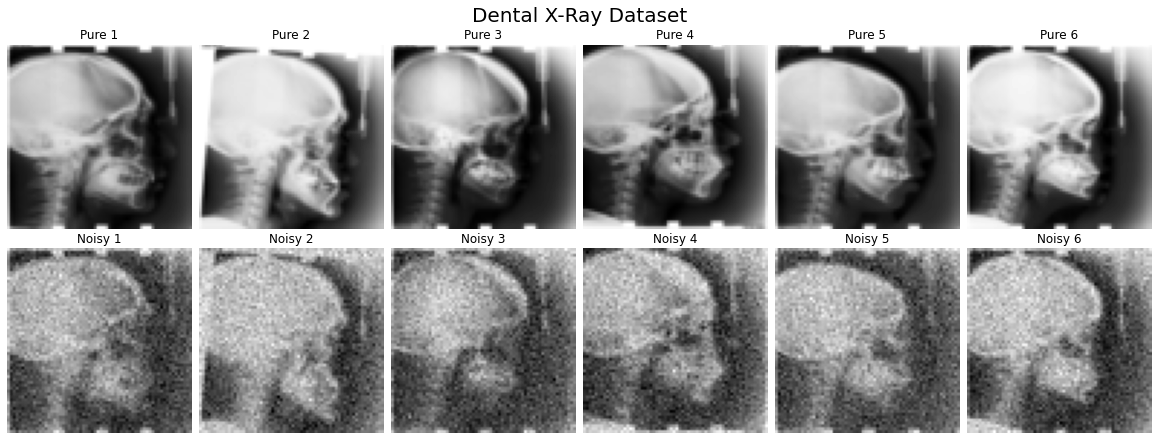

In [6]:
fig, axes = plt.subplots(2, 6, figsize=(16, 7), constrained_layout=True)
axes = list(map(list, zip(*axes)))
fig.suptitle("Dental X-Ray Dataset", fontsize=20)

for i, (ax1, ax2) in enumerate(axes):
    pure_img, _ = train_dataset[i]
    pure_img = pure_img.permute(1, 2, 0)

    ax1.imshow(pure_img, cmap="gray")
    ax1.axis("off")
    ax1.set_title(f"Pure {i+1}", fontsize=16)

    noisy_img = add_noise(pure_img)
    ssim_val = ssim(pure_img.numpy(), noisy_img.numpy())
    ax2.imshow(noisy_img, cmap="gray")
    ax2.axis("off")
    ax2.set_title(f"Noisy {i+1}\n(SSIM: {ssim_val:.3f})", fontsize=16)


### Build & Train CNN based AutoEncoder Model

<generator object Module.parameters at 0x00000130FC18D0B0>
Training started...


C:\Python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1	[0/360 (0%)]	Loss: 0.069164
Epoch: 1	[100/360 (28%)]	Loss: 0.059486
Epoch: 1	[200/360 (56%)]	Loss: 0.054755
Epoch: 1	[300/360 (83%)]	Loss: 0.052138
Epoch: 2	[0/360 (0%)]	Loss: 0.053832
Epoch: 2	[100/360 (28%)]	Loss: 0.052570
Epoch: 2	[200/360 (56%)]	Loss: 0.052833
Epoch: 2	[300/360 (83%)]	Loss: 0.052837
Epoch: 3	[0/360 (0%)]	Loss: 0.053212
Epoch: 3	[100/360 (28%)]	Loss: 0.049364
Epoch: 3	[200/360 (56%)]	Loss: 0.052767
Epoch: 3	[300/360 (83%)]	Loss: 0.052238
Epoch: 4	[0/360 (0%)]	Loss: 0.053938
Epoch: 4	[100/360 (28%)]	Loss: 0.051776
Epoch: 4	[200/360 (56%)]	Loss: 0.050555
Epoch: 4	[300/360 (83%)]	Loss: 0.053491
Epoch: 5	[0/360 (0%)]	Loss: 0.051069
Epoch: 5	[100/360 (28%)]	Loss: 0.050439
Epoch: 5	[200/360 (56%)]	Loss: 0.051884
Epoch: 5	[300/360 (83%)]	Loss: 0.051660
Epoch: 6	[0/360 (0%)]	Loss: 0.051737
Epoch: 6	[100/360 (28%)]	Loss: 0.051692
Epoch: 6	[200/360 (56%)]	Loss: 0.052354
Epoch: 6	[300/360 (83%)]	Loss: 0.051028
Epoch: 7	[0/360 (0%)]	Loss: 0.051789
Epoch: 7	[100/360 (28

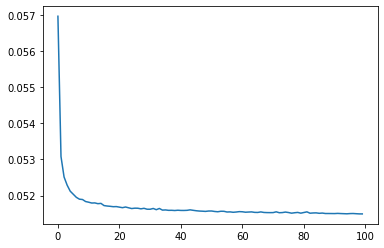

In [7]:
model = AutoEncoderCNN()
model.to(device)
print(model.parameters())

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

train_losses = train(
    model,
    train_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=100,
    device=device,
    save_dir=DENTALXRAY_MODEL_DIR,
)

plt.plot(train_losses)


### Test the model


In [8]:
model = AutoEncoderCNN()
model.load_state_dict(torch.load(DENTALXRAY_MODEL_DIR / "autoencodercnn_epoch_100.pth"))
model.to(device)

noisy_imgs, denoised_imgs = test(model, test_loader, criterion=criterion, device=device)


Average test loss: 0.052514


### Visualize results

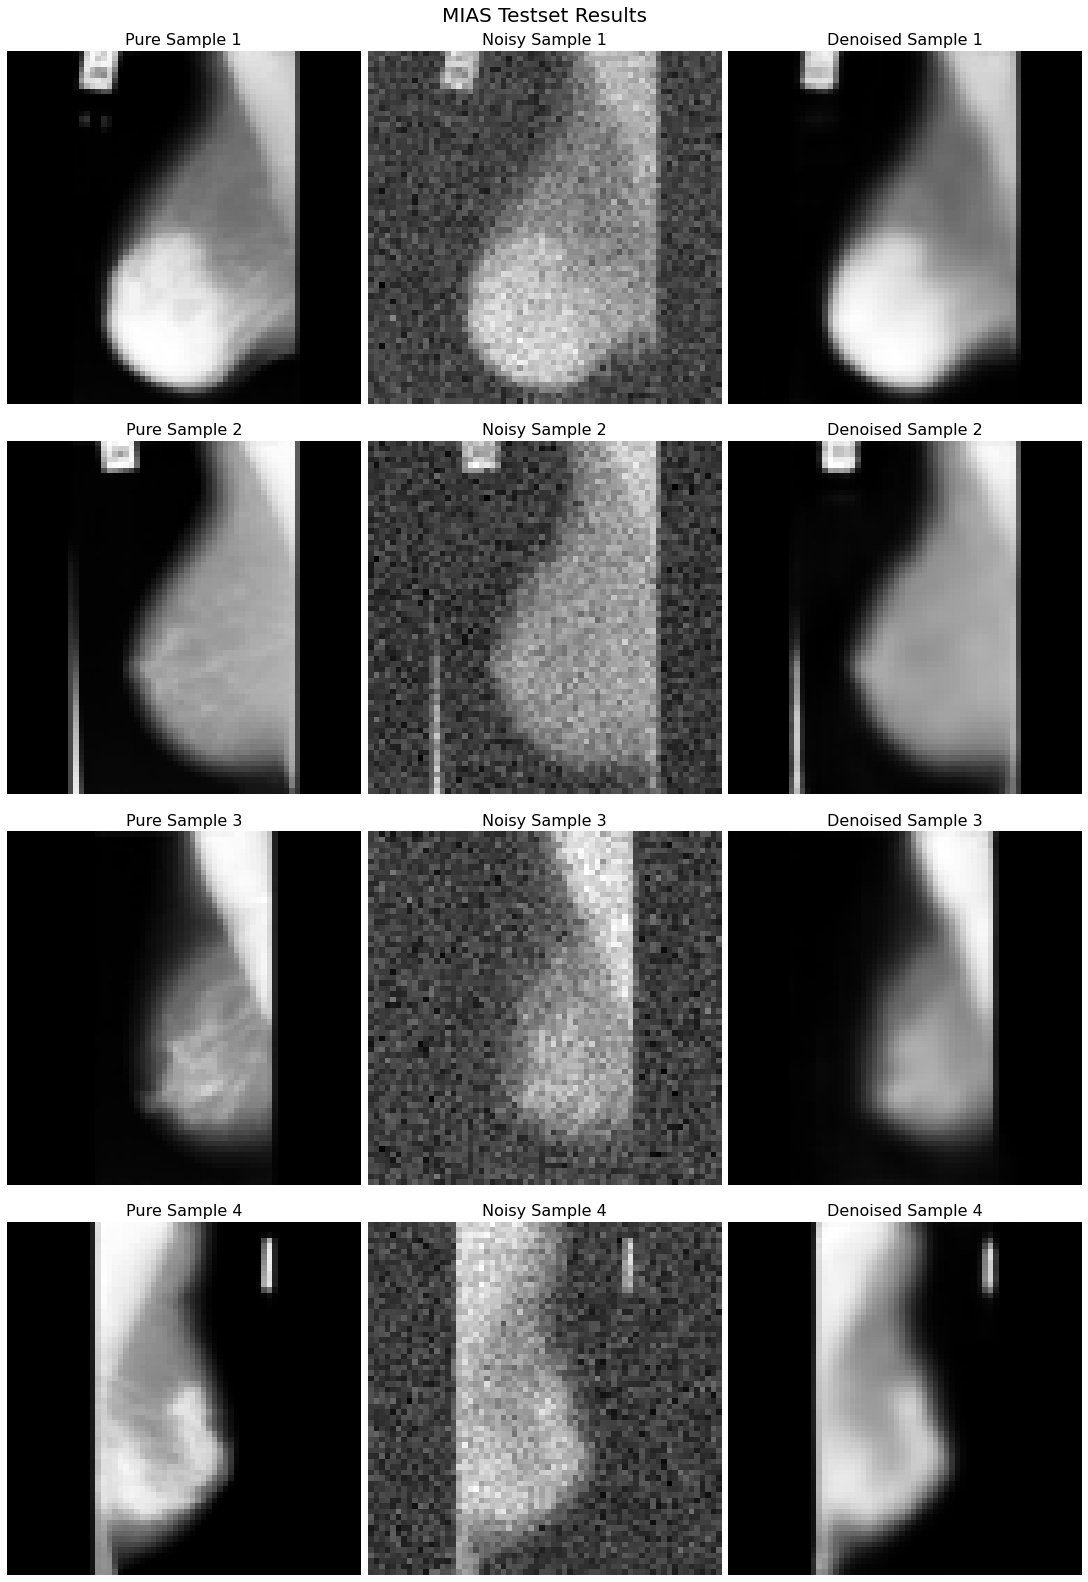

In [181]:
fig, axes = plt.subplots(4, 3, figsize=(8, 13), constrained_layout=True)
fig.suptitle("Dental XRay Testset Results", fontsize=20)

for i, ax in enumerate(axes):
    ax[0].imshow(test_dataset[i][0].permute(1, 2, 0), cmap="gray")
    ax[0].axis("off")
    ax[0].set_title(f"Pure Sample {i+1}", fontsize=16)

    ax[1].imshow(noisy_imgs[i].permute(1, 2, 0), cmap="gray")
    ax[1].axis("off")
    ax[1].set_title(f"Noisy Sample {i+1}", fontsize=16)

    ax[2].imshow(denoised_imgs[i].permute(1, 2, 0), cmap="gray")
    ax[2].axis("off")
    ax[2].set_title(f"Denoised Sample {i+1}", fontsize=16)


### Visualize noisy data


NameError: name 'add_noise' is not defined

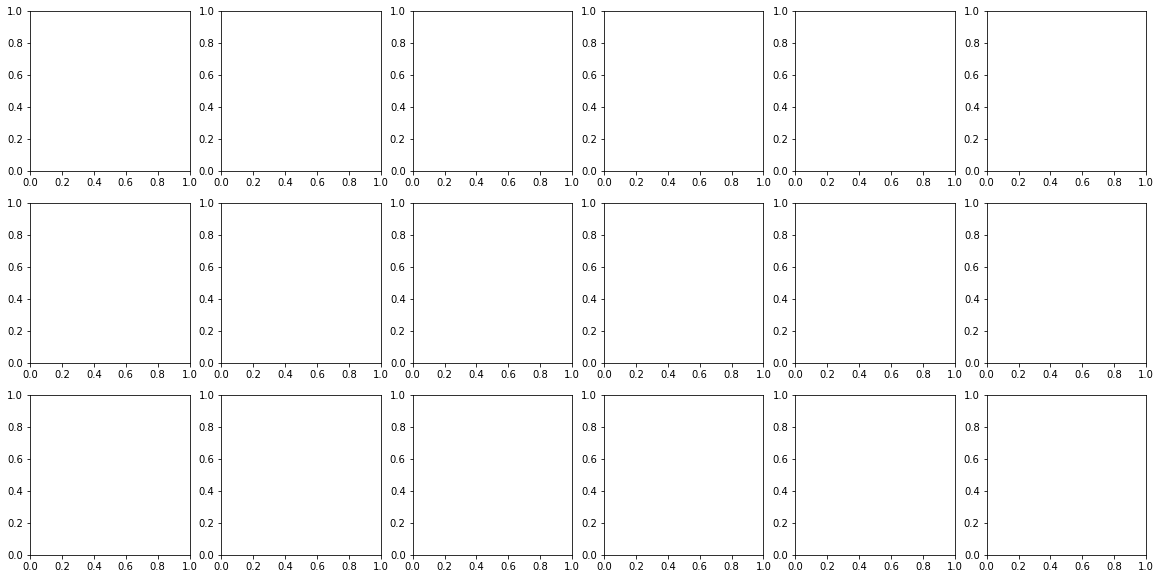

In [43]:
fig, axes = plt.subplots(3, 6, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    fig_img, fig_label = train_dataset[i]
    fig_img = add_noise(fig_img)
    fig_img = fig_img.permute(1, 2, 0)

    ax.imshow(fig_img, cmap="gray")
    ax.axis("off")
    ax.set_title(f"Noisy Sample {i+1}")


In [ ]:
model = AutoEncoderCNN()
model.to(device)
print(model.parameters())

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

train_losses = train(
    model,
    train_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=100,
    device=device,
)
plt.plot(train_losses)


Training started...
Epoch: 1	[0/289 (0%)]	Loss: 0.704611
Epoch: 1	[100/289 (34%)]	Loss: 0.344522
Epoch: 1	[200/289 (69%)]	Loss: 0.282831
Epoch: 2	[0/289 (0%)]	Loss: 0.322209
Epoch: 2	[100/289 (34%)]	Loss: 0.256273
Epoch: 2	[200/289 (69%)]	Loss: 0.265733
Epoch: 3	[0/289 (0%)]	Loss: 0.255340
Epoch: 3	[100/289 (34%)]	Loss: 0.262918
Epoch: 3	[200/289 (69%)]	Loss: 0.289028
Epoch: 4	[0/289 (0%)]	Loss: 0.276869
Epoch: 4	[100/289 (34%)]	Loss: 0.346080
Epoch: 4	[200/289 (69%)]	Loss: 0.235650
Epoch: 5	[0/289 (0%)]	Loss: 0.266569
Epoch: 5	[100/289 (34%)]	Loss: 0.295604
Epoch: 5	[200/289 (69%)]	Loss: 0.273900
Epoch: 6	[0/289 (0%)]	Loss: 0.262127
Epoch: 6	[100/289 (34%)]	Loss: 0.244107
Epoch: 6	[200/289 (69%)]	Loss: 0.302929
Epoch: 7	[0/289 (0%)]	Loss: 0.245000
Epoch: 7	[100/289 (34%)]	Loss: 0.251016
Epoch: 7	[200/289 (69%)]	Loss: 0.239555
Epoch: 8	[0/289 (0%)]	Loss: 0.282680
Epoch: 8	[100/289 (34%)]	Loss: 0.215189
Epoch: 8	[200/289 (69%)]	Loss: 0.264929
Epoch: 9	[0/289 (0%)]	Loss: 0.279144
Epoch: 

In [ ]:
model = AutoEncoderCNN()
model.load_state_dict(torch.load(MIAS_MODEL_DIR / "autoencodercnn_mias_epoch_100.pth"))
model.to(device)

noisy_imgs, denoised_imgs = test(model, test_loader, device=device)


Average test loss: 0.029057


### Visualize results

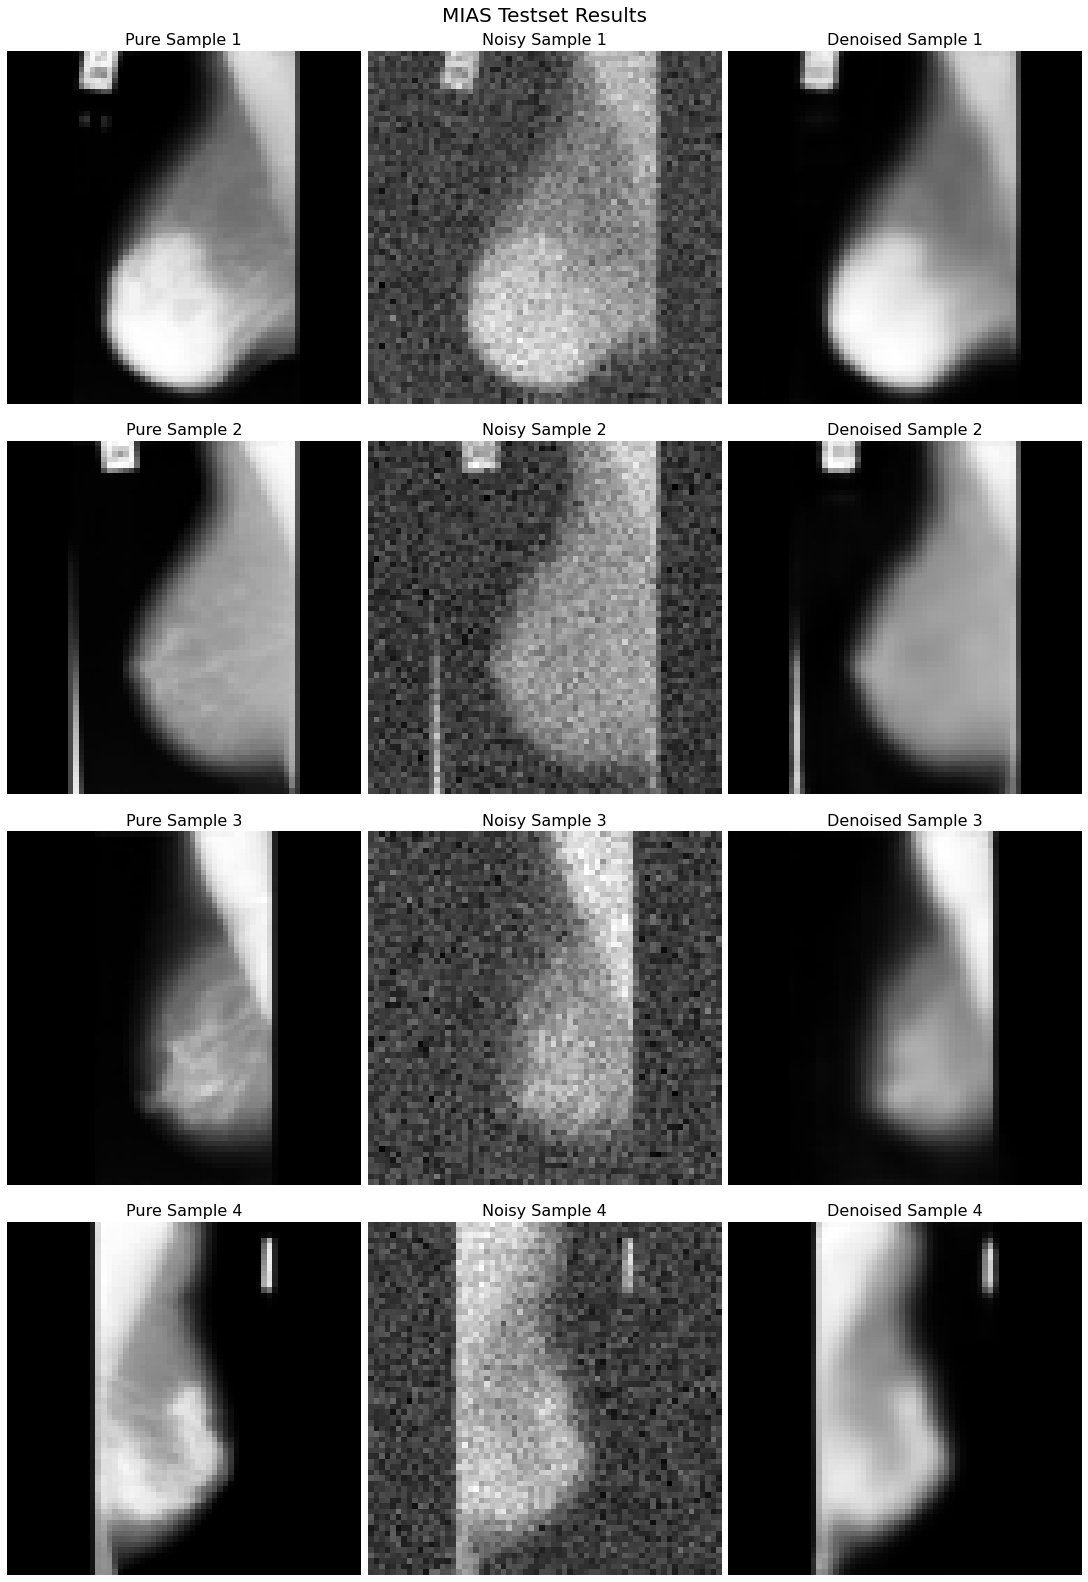

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(15, 22), constrained_layout=True)
fig.suptitle("Dental XRay Testset Results", fontsize=20)

for i, ax in enumerate(axes):
    ax[0].imshow(test_dataset[i][0].permute(1, 2, 0), cmap="gray")
    ax[0].axis("off")
    ax[0].set_title(f"Pure Sample {i+1}", fontsize=16)

    ax[1].imshow(noisy_imgs[i].permute(1, 2, 0), cmap="gray")
    ax[1].axis("off")
    ax[1].set_title(f"Noisy Sample {i+1}", fontsize=16)

    ax[2].imshow(denoised_imgs[i].permute(1, 2, 0), cmap="gray")
    ax[2].axis("off")
    ax[2].set_title(f"Denoised Sample {i+1}", fontsize=16)
